In [13]:
%matplotlib inline

In [14]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [15]:
#Define a function that removes x & y ticks from images
def noticks():
    """Remove the x & y ticks from the axes of figures."""
    ax = plt.gca()
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

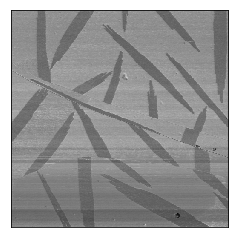

In [16]:
#Import the local image and plot it
img = mpimg.imread('./PTCDITest2.png')
imgplot = plt.imshow(img,cmap="gray")
noticks()

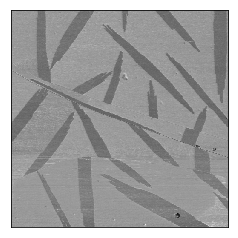

In [17]:
#Before processing, need to equalise the background so thresholding works:

#Find the background height along each row using the 70th percentile
bg = np.percentile(img, 70, axis=1, keepdims=True)

#Using the minimum background height and use it to create a scalar for each row
min = np.amin(bg)
scalar_array = min/bg

#Multiple each row by the associated scalar and plot to observe results
flat_img = [scalar_array[i]*img[i,:] for i in range(len(img))]
imgplot = plt.imshow(flat_img,cmap="gray")
noticks()

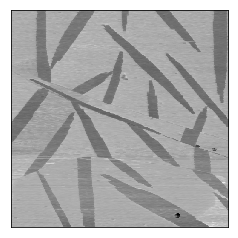

In [18]:
#Apply a 2D percentile filter to the flattened image to improve edges
img_perc=ndimage.filters.percentile_filter(flat_img,40,size=(1,7))
img_percplot = plt.imshow(img_perc,cmap="gray")
noticks()

In [19]:
#Create an array of threshold values and a blank array to store the number of zeroes in the
#binary images produced by each value
threshold=np.arange(0, 1, 0.01)
num_zeroes_arr = np.array([])

#Deploy a for loop that thresholds the filtered image using each#threshold value and stores
#the number of zeroes in the binary image produced for each value
for i,j in enumerate(threshold):
    img_test=img_perc
    img_test=img_test>j
    num_zeroes_i = (img_test == 0).sum()
    num_zeroes_arr = np.append(num_zeroes_arr, num_zeroes_i)

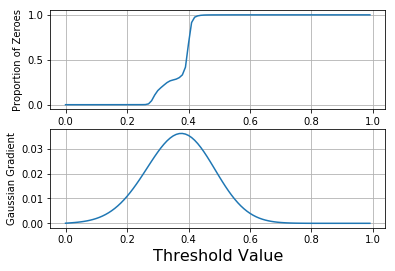

In [20]:
#Find the index of the optimal threshold by considering where the proportion of zeroes in the
#binary image changes the least, using a Gaussian gradient function
opt_ind=np.argmax(ndimage.gaussian_gradient_magnitude(num_zeroes_arr,10))

#Plot graphs of the proportion and its gradient to visually confirm the correct index being
#selected
plt.subplot(211)
threshold_plot=plt.plot(threshold,num_zeroes_arr/np.amax(num_zeroes_arr))
plt.ylabel('Proportion of Zeroes')
plt.grid(True)

plt.subplot(212)
threshold_grad_plot=plt.plot(threshold,ndimage.gaussian_gradient_magnitude(num_zeroes_arr/np.amax(num_zeroes_arr),10))
plt.ylabel('Gaussian Gradient')
plt.xlabel('Threshold Value', fontsize=16);
plt.grid(True)

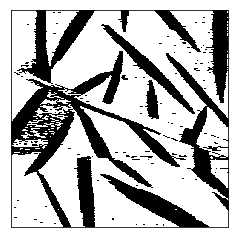

In [21]:
#Generate the found optimal binary image for further filtering
opt_img=img_perc>threshold[opt_ind]
opt_plot=plt.imshow(opt_img,cmap="gray")
noticks()

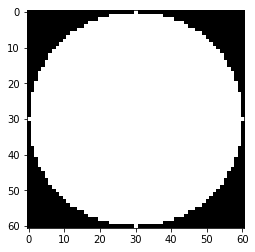

In [22]:
#Write a small function to make a circular structuring element for morphological image
#processing
def bin_circ_se(r):
    """Creates a circular binary structuring element of integer pixel radius r>1."""
    nx,ny=(2*r+1,2*r+1)
    x=np.arange(nx)
    y=np.arange(ny)
    xv, yv = np.meshgrid(x, y)
    circle = np.square(yv - r) + np.square(xv - r) <= np.square(r)
    circle=np.array(circle)
    return circle

#Create and plot a sample of the binary circle of radius 30
seplot=plt.imshow(bin_circ_se(30), cmap='gray')

Flake Coverage = 28.0%.


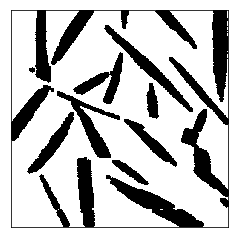

In [23]:
#Perform a morphological binary closing on the image in order to remove non-flake
#features and noise from the image:

#Binary closing creates a seam on the image, this is circumvented by padding the image
#with 1s, applying the process and then removing the padding.
pad_width=100
opt_img_pad = np.pad(opt_img, [(pad_width, ), (pad_width, )], mode='constant',constant_values=1)

#Perform binary closing using a circular binary structuring element of radius 5
opt_img_closed = ndimage.binary_closing(opt_img_pad, structure=bin_circ_se(5))

#Remove the padding and plot the final resulting image
opt_img_closed = opt_img_closed[pad_width:-pad_width, pad_width:-pad_width]
opt_imgplot = plt.imshow(opt_img_closed, cmap='gray')
noticks()

#Print the percentage flake coverage of the last image
cov=(opt_img_closed == 0).sum()/(opt_img_closed.size)*100
print('Flake Coverage = {0:.1f}%.'.format(cov))